In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from src.preprocessing.preprocessing import load_and_split_data, NUM_CLASSES 
from src.models.model_definition import create_vgg16_transfer_model

C:\Users\alber\food-recognition\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
BATCH_SIZE = 32
train_ds, val_ds, test_ds, ds_info = load_and_split_data(batch_size=BATCH_SIZE)

In [5]:
model = create_vgg16_transfer_model(input_shape=(224, 224, 3))
model.summary()

Model: "VGG16_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,979,396
Trainable params: 264,708
Non-trainable params: 14,714,688
_____________________________________

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,        
    restore_best_weights=True
)


In [7]:
model_checkpoint = ModelCheckpoint(
    filepath='models/best_vgg16_4class.h5', 
    monitor='val_accuracy', 
    mode='max', 
    save_best_only=True
)

In [8]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        callbacks=[early_stopping, model_checkpoint]
    )
model.save('models/final_vgg16_4class.h5')

Epoch 1/50
65/65 [==============================] - 70s 660ms/step - loss: 2.2141 - accuracy: 0.6500 - val_loss: 0.6089 - val_accuracy: 0.8547
Epoch 2/50
65/65 [==============================] - 58s 562ms/step - loss: 0.8074 - accuracy: 0.7742 - val_loss: 0.4327 - val_accuracy: 0.8463
Epoch 3/50
65/65 [==============================] - 59s 560ms/step - loss: 0.5505 - accuracy: 0.8199 - val_loss: 0.4235 - val_accuracy: 0.8568
Epoch 4/50
65/65 [==============================] - 60s 594ms/step - loss: 0.4664 - accuracy: 0.8353 - val_loss: 0.3571 - val_accuracy: 0.8695
Epoch 5/50
65/65 [==============================] - 64s 607ms/step - loss: 0.4353 - accuracy: 0.8479 - val_loss: 0.3470 - val_accuracy: 0.8800
Epoch 6/50
65/65 [==============================] - 58s 556ms/step - loss: 0.3883 - accuracy: 0.8541 - val_loss: 0.3694 - val_accuracy: 0.8695
Epoch 7/50
65/65 [==============================] - 58s 552ms/step - loss: 0.3553 - accuracy: 0.8652 - val_loss: 0.3270 - val_accuracy: 0.8779

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Trening Accuracy')
    plt.plot(epochs_range, val_acc, label='Walidacja Accuracy')
    plt.legend(loc='lower right')
    plt.title('Dokładność (Accuracy)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Trening Loss')
    plt.plot(epochs_range, val_loss, label='Walidacja Loss')
    plt.legend(loc='upper right')
    plt.title('Strata (Loss)')
    plt.grid(True)
    
    plt.show()

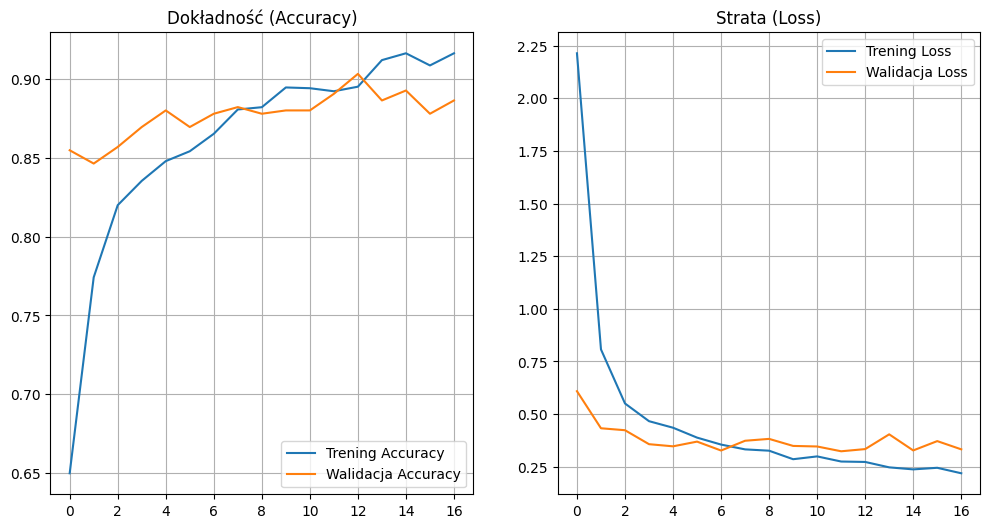

In [10]:
plot_training_history(history)